## Table of Content:
* [Introduction](#first-bullet)
* [Network](#second-bullet)
* [Distribution](#third-bullet)
* [Wordclouds](#fourth-bullet)
* [References](#fifth-bullet)
* [Explainer Notebook](#sixth-bullet)

-------------------
<a class="anchor" id="first-bullet"></a>

# A deep dive into the scene of Hip Hop artists 

In [70]:
import pandas as pd
import numpy as np

import re
import matplotlib


import urllib.request
from urllib.parse import urlparse
from urllib.request import urlopen

import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer 
from urllib.request import urlopen
from nltk.corpus import PlaintextCorpusReader

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import json

import networkx as nx
from random import choice
from random import sample

import matplotlib.pyplot as plt

from fa2 import ForceAtlas2

import warnings
warnings.filterwarnings("ignore")

import cleantext
import nltk
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

import community
import seaborn as sns


In [71]:
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
title = "titles="+ "List_of_hip_hop_musicians"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

wikiresponse = urllib.request.urlopen(query)
wikidata = wikiresponse.read()
wikitext = wikidata.decode('utf-8')

linklist  = re.findall("\[\[(.*?)\]\]", wikitext)

### Introducing the complete website that gives you the full overview of all Hip Hop artist in history and looks into the biggest artist from each community. 

In [72]:
hiphop_artist= pd.read_excel("hiphop_artist1.xlsx")
hiphop_artist = hiphop_artist['50 Cent'].tolist()

names = []
links = []
for i in range(len(linklist)):
    
    linklist[i]= linklist[i].split("|")[0]
    linklist[i]= re.sub(r'\([^)]*\)', '', linklist[i])

    if linklist[i] in hiphop_artist:
        names.append(linklist[i])
        links.append(re.sub(r' ', '_', linklist[i]))


d = {'names': names, 'links': links,}
df = pd.DataFrame(data=d)


In [73]:
%%capture

# Function to retrieve content of wikipedia pages
# input: dataframe containing links to pages, and path where file should be saved
path = "C:\\Users\\Bruger\\Documents\\Semester 10\\Social Graphs\\artist3\\"
baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
redirects = "redirects"

# nltk.download('stopwords') 
unique_words = []
all_words = []
all_unique_words = []
words = " "
words_unique = " "

tot_words = []
artist = []
for link in df['links']:

    try: 
        title = link
        query = "{}{}&{}&titles={}&{}&{}".format(baseurl, action, content, title, dataformat, redirects)

        # fix utf8
        query = query.replace("é", "%C3%A9")
        query = query.replace("á","%C3%A1")
        query = query.replace("í","%C3%AD")
        query = query.replace("ë","%C3%AB")
        query = query.replace("ä","%C3%A4")
        query = query.replace("ó","%C3%B3")
        query = query.replace("Á","%C3%81")

        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        text = wikidata.decode('utf-8')

        tk = WordPunctTokenizer()
        wikijson = tk.tokenize(str(text))

        full_path=path+link+ ".txt"

        f = open(full_path, "w+", encoding="utf-8")

        f.write(str(wikidata))
    except:
        test = link
    

In [74]:
def get_adjectives(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if tag == "JJ"]

In [75]:
%%capture
import requests
import mwparserfromhell

# Function to retrieve content of wikipedia pages
# input: dataframe containing links to pages, and path where file should be saved

baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"
redirects = "redirects"

# nltk.download('stopwords') 
unique_words = []
all_words = []
all_unique_words = []
words = " "
words_unique = " "

tot_words = []
artist = []

for link in df['links']:
    
    try:
        response = requests.get('https://en.wikipedia.org/w/api.php',params={
            'action': 'query',
            'format': 'json',
            'titles': link,
            'prop': 'revisions',
            'rvprop': 'content',}).json()
        page = next(iter(response['query']['pages'].values()))
        wikicode = page['revisions'][0]['*']
        parsed_wikicode = mwparserfromhell.parse(wikicode)
        text = parsed_wikicode.strip_code()

        text = re.sub(r'\b\w{1,3}\b', '', text)

        wikijson = get_adjectives(text)


        wikijson_alpha = []
        for j in range(len(wikijson)):                
            wikijson_alpha.append(re.sub(r'[^a-zA-Z]','', wikijson[j]).lower())

        lemma=[]
        lemmatizer = WordNetLemmatizer()
        for k in range(len(wikijson_alpha)):
            lemma.append(lemmatizer.lemmatize(wikijson_alpha[k]))

        all_words.append(lemma)
        all_unique_words.append(np.unique(lemma))
        artist.append(link)

    except: 
        print(link)

In [76]:
words_unique = []
for i in range(len(all_unique_words)):
    for j in range(len(all_unique_words[i])):
        words_unique.append(all_unique_words[i][j]) 

In [77]:
words = sum(all_words, [])
words = np.unique(words)

unique_words = np.unique(words)

IDF =[]
IDF_words =[]
word_doc_count = []

for i in range(len(unique_words)):
    
    IDF.append(len(all_words) / words_unique.count(unique_words[i]))
    word_doc_count.append(words_unique.count(unique_words[i]))
    IDF_words.append(unique_words[i])

In [78]:
node_description=[]
artists_links=[]
artists=[]
linker = []
origin = []

path = "C:\\Users\\Bruger\\Documents\\Semester 10\\Social Graphs\\artist3\\"
for i in range(len(df)):

    linker = []
    node_description =[]
    try:
        with open(path+df['links'][i]+'.txt',"r", encoding="utf-8") as f:

            node_description.append(f.read())

            finder  = re.findall("\[\[(.*?)\]\]", str(node_description))

            origin.append(re.findall("origin = \\W+(\\w+)", str(node_description)))


            for j in range(len(finder)):
                if finder[j] in hiphop_artist:
                    linker.append(finder[j])

            linker = list(dict.fromkeys(linker))

            artists_links.append(linker)
            artists.append(df['names'][i])

    except:
        test = link
    

<img src="photo1.jpg" width="700" height="240" align="center"/>


In [79]:
G = nx.DiGraph()

for i in range(len(artists)):
    
    G.add_node(artists[i])

for i in range(len(artists_links)):
    for j in range(len(artists_links[i])):
        if artists_links[i][j] in list(artists):
            G.add_edges_from([[artists[i], artists_links[i][j]]])

        
remover = [node for node, degree in dict(G.degree()).items() if degree < 50]
G.remove_nodes_from(remover)

In [80]:
d_ = dict(G.degree)
dict_ = dict(sorted(d_.items(), key=lambda item: item[1]))
val_ = list(dict_.values())

d_in = dict(G.in_degree)
dict_in = dict(sorted(d_in.items(), key=lambda item: item[1]))
val_in = list(dict_in.values())

d_out = dict(G.out_degree)
dict_out = dict(sorted(d_out.items(), key=lambda item: item[1]))
val_out = list(dict_out.values())

In [81]:
# Ready graph for plotting
H = G.to_undirected()
H.remove_edges_from(list(nx.selfloop_edges(H)))
GCC = max((H.subgraph(c) for c in nx.connected_components(H)), key=len)
nodeDict = dict(GCC.nodes(data=True))

In [82]:
%%capture
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=20.0,
                        strongGravityMode=False,
                        gravity=0.5,

                        # Log
                        verbose=True);

# Determine node positions
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=2000);

In [83]:
import community
import seaborn as sns

nodes = []
colors = []
partition = community.best_partition(GCC)
count=0

colormap = []
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nodes.append(list_nodes)

pal = sns.color_palette('Paired', 7)
pal.as_hex()[1]
for i in range(len(artists)):        
    if artists[i] in nodes[0]:
        colormap.append(str(matplotlib.colors.to_hex(sns.color_palette("cividis")[0])))
    elif artists[i] in nodes[1]:
        colormap.append(str(matplotlib.colors.to_hex(sns.color_palette("cividis")[1])))
    elif artists[i] in nodes[2]:
        colormap.append(str(matplotlib.colors.to_hex(sns.color_palette("cividis")[3])))
    elif artists[i] in nodes[3]:
        colormap.append(str(matplotlib.colors.to_hex(sns.color_palette("cividis")[4])))
    else:
        colormap.append(str(matplotlib.colors.to_hex(sns.color_palette("cividis")[2])))


In [84]:
from pyvis import network as net
from pyvis.network import Network

In [85]:
xpos = {}
ypos = {}
for n in positions:
    xpos[n] = positions[n][0]
    ypos[n] = positions[n][1]
    
size_dict = {}
for n in nodeDict:
    size_dict[n] = GCC.degree[n]/10
    

<a class="anchor" id="second-bullet"></a>

# The complete overview

To kick off, we start with the full overview of all the Hip Hop artist in the world. In the graph you see all artist represented as circles, that increase in size the more references it has from other artist. The colours represent what "community" the artists are grouped in. Artist with more than 15 references will have their name displayed.
The plot is interactive so dive in! 

From the plot you see that the different communities represent different subgenres. The yellow represent the older artist from the 90's, like Eminem, Nas and Busta Rhymes together with the dark blue group as Dr. Dre, Ice Cube and Snoop Dogg. The plot show that these two groups are rather merged toghether. On the other hand, you have the blue and gray group with more pop related artist, as Kanye West, Chris Brown and Nicki Minaj. Finally there is the brown group with a rather more modern twist like Kendrick Lamar, Anderson Paak and Pharrell Williams. Even though there are some clear patterns of subgenres in the graph there are many artist that doesn't belong in that subgenre, but that the algorithm is not perfect and that links to a wikipage to another is not a perfect way of connecting artist based on the genre. One example is that 50 Cent probably doesn’t belong to a pop-related subgenre nor Action Bronson belong to old school hip hop genre.

In [86]:
pyvis_graph = net.Network(notebook=True, height='40%', width='60%', bgcolor='white', font_color='black')

pyvis_graph.show_buttons(filter_=['physics'])

nx.set_node_attributes(GCC, xpos, "x")
nx.set_node_attributes(GCC, ypos, "y")

pyvis_graph.width = '800px'
pyvis_graph.height = '800px'

pyvis_graph.toggle_physics(False)

for i in range(len(artists)):
    
    try: 
        if size_dict[artists[i]] > 1.5:
            pyvis_graph.add_node(artists[i], x=xpos[artists[i]], y= ypos[artists[i]], size = size_dict[artists[i]]*5, 
                                 label = artists[i], color = colormap[i])
        else:
            pyvis_graph.add_node(artists[i], x=xpos[artists[i]], y= ypos[artists[i]], size = size_dict[artists[i]]*5, 
                                 label = " ", color = colormap[i])
    except:
        test=1

for i in range(len(artists_links)):
    for j in range(len(artists_links[i])):
        if artists_links[i][j] in artists:
            try: 
                pyvis_graph.add_edge(artists[i],artists_links[i][j], width = 0.01, color = 'gray')
            except:
                test=1
pyvis_graph.show_buttons(filter_=['renderer'])
# pyvis_graph.show('test.html')


In [87]:
pyvis_graph.save_graph('test.html')
# pyvis_graph.show('test.html')

In [88]:
pyvis_graph.write_html('test.html', notebook=True)


In [89]:
# pyvis_graph.prep_notebook()
# pyvis_graph.show("test.html")

In [90]:
index_artist = artist.index("Eminem") 

words_snoop = all_words[index_artist]
    
TF = []
for j in range(len(words_snoop)):
    TF.append(words_snoop.count(words_snoop[j]) / len(words_snoop))
    
TF_IDF = []

for j in range(len(words_snoop)):
    TF_IDF.append(IDF[IDF_words.index(words_snoop[j])]*TF[j])
    
wordsForCloud_snoop =[]
for j in range(len(words_snoop)):
    for i in range(int(round(TF_IDF[j]))):
        wordsForCloud_snoop.append(words_snoop[j])
        
joined = ",".join(wordsForCloud_snoop)

wordcloud1 = WordCloud(background_color='white',
                      width=2400,
                      height=1400, collocations=False, colormap="cividis"
                     ).generate(joined)
index_artist = artist.index("Nas") 
# index_artist = artist.index("2_Black_2_Strong") 

words_snoop = all_words[index_artist]
    
TF = []
for j in range(len(words_snoop)):
    TF.append(words_snoop.count(words_snoop[j]) / len(words_snoop))
    
TF_IDF = []

for j in range(len(words_snoop)):
    TF_IDF.append(IDF[IDF_words.index(words_snoop[j])]*TF[j])
    
wordsForCloud_snoop =[]
for j in range(len(words_snoop)):
    for i in range(int(round(TF_IDF[j]))):
        wordsForCloud_snoop.append(words_snoop[j])
        
joined = ",".join(wordsForCloud_snoop)

wordcloud2 = WordCloud(background_color='white',
                      width=2400,
                      height=1400, collocations=False, colormap="cividis"
                     ).generate(joined)
index_artist = artist.index("50_Cent") 
# index_artist = artist.index("2_Chainz") 

words_snoop = all_words[index_artist]
    
TF = []
for j in range(len(words_snoop)):
    TF.append(words_snoop.count(words_snoop[j]) / len(words_snoop))
    
TF_IDF = []
for j in range(len(words_snoop)):
    TF_IDF.append((IDF[IDF_words.index(words_snoop[j])])*TF[j])
    
wordsForCloud_snoop =[]
for j in range(len(words_snoop)):
    for i in range(int(round(TF_IDF[j]))):
        wordsForCloud_snoop.append(words_snoop[j])
        
joined = ",".join(wordsForCloud_snoop)

wordcloud3 = WordCloud(background_color='white',
                      width=2400,
                      height=1400, collocations=False, colormap="cividis"
                     ).generate(joined)
index_artist = artist.index("Kanye_West") 
# index_artist = artist.index("1.Cuz") 

words_snoop = all_words[index_artist]
    
TF = []
for j in range(len(words_snoop)):
    TF.append(words_snoop.count(words_snoop[j]) / len(words_snoop))
    
TF_IDF = []

for j in range(len(words_snoop)):
    TF_IDF.append(IDF[IDF_words.index(words_snoop[j])]*TF[j])
    
wordsForCloud_snoop =[]
for j in range(len(words_snoop)):
    for i in range(int(round(TF_IDF[j]))):
        wordsForCloud_snoop.append(words_snoop[j])
        
joined = ",".join(wordsForCloud_snoop)

wordcloud4 = WordCloud(background_color='white',
                      width=2400,
                      height=1400, collocations=False, colormap="cividis"
                     ).generate(joined)
index_artist = artist.index("Missy_Elliott") 
# index_artist = artist.index("070_Shake") 

words_snoop = all_words[index_artist]
    
TF = []
for j in range(len(words_snoop)):
    TF.append(words_snoop.count(words_snoop[j]) / len(words_snoop))
    
TF_IDF = []

for j in range(len(words_snoop)):
    TF_IDF.append(IDF[IDF_words.index(words_snoop[j])]*TF[j])
    
wordsForCloud_snoop =[]
for j in range(len(words_snoop)):
    for i in range(int(round(TF_IDF[j]))):
        wordsForCloud_snoop.append(words_snoop[j])
        
joined = ",".join(wordsForCloud_snoop)

wordcloud5 = WordCloud(background_color='white',
                      width=2400,
                      height=1400, collocations=False, colormap="cividis"
                     ).generate(joined)

<a class="anchor" id="third-bullet"></a>

# Degree distribution

The degree disribution show how many links or references each artist has, which include both outgoing and ingoing links. From the degree distribution the majority of artist has 10 to 40 links and the more popular artist goes up to 100 links. High amount of links also show that an artist may have collaborated with many other artist. Maybe an artist is very big, but have went solo her/his whole career and may not have many links to other artists, so links does not necessarily mean greater artist. 
The in and out-degree distribution plot is rather similar. The in-degree distribution have most artist from 5 to 20 links where the out-degree distribution have ore from 10 to 30 links.

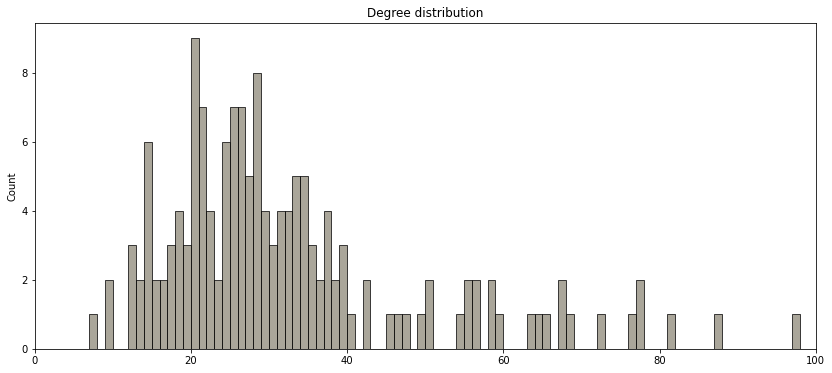

In [91]:
fig = plt.figure(figsize=[14,6])


g1 = sns.histplot(val_, bins=np.arange(-0, 100, 1), color=sns.color_palette("cividis")[3])

g1.set_xlim(0,100)

g1.set_title('Degree distribution')


plt.show()


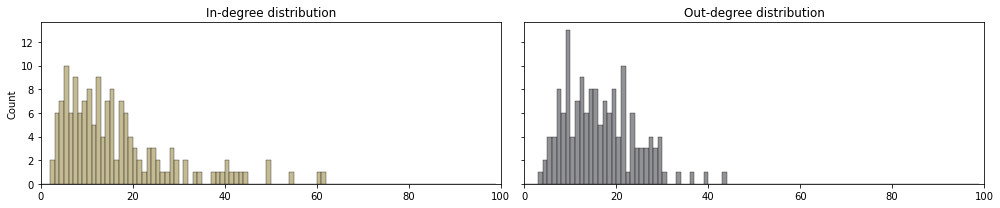

In [92]:
fig, axes = plt.subplots(1, 2, figsize=[14,3], sharey= True)

g1 = sns.histplot(val_in, bins=np.arange(0, 100, 1), ax=axes[0], color=sns.color_palette("cividis")[4])
g2 = sns.histplot(val_out,bins=np.arange(0, 100, 1), ax=axes[1], color=sns.color_palette("cividis")[2])

g1.set_xlim(0,100)
g2.set_xlim(0,100)


g1.set_title('In-degree distribution')
g2.set_title('Out-degree distribution')
plt.tight_layout()
plt.show()

<a class="anchor" id="fourth-bullet"></a>

# Frontrunners

Now it's time to dive into the frontrunners of the different communities. The word cloud is generated from entire wikipages of the artist. One of Eminems most common words are 'shady' as this is part of his other nick name. Skylar is refereing to Skylar Grey who he has featured with many times through his career. Kanye West's most common word is kardashian which is his wife and their relationship have become world famous. One of Nas' most common word is illmatic which is the name of his debut album which also became world famous. One of 50 Cent's most famous words is dietary, as has always been known having ripped body.  

These words are obviously not the most accourate words related to these artist. As the big data-cleaning part involves a lot of manipulation with words and filtering along with the mathematical function used, to exctract the most unique words. 

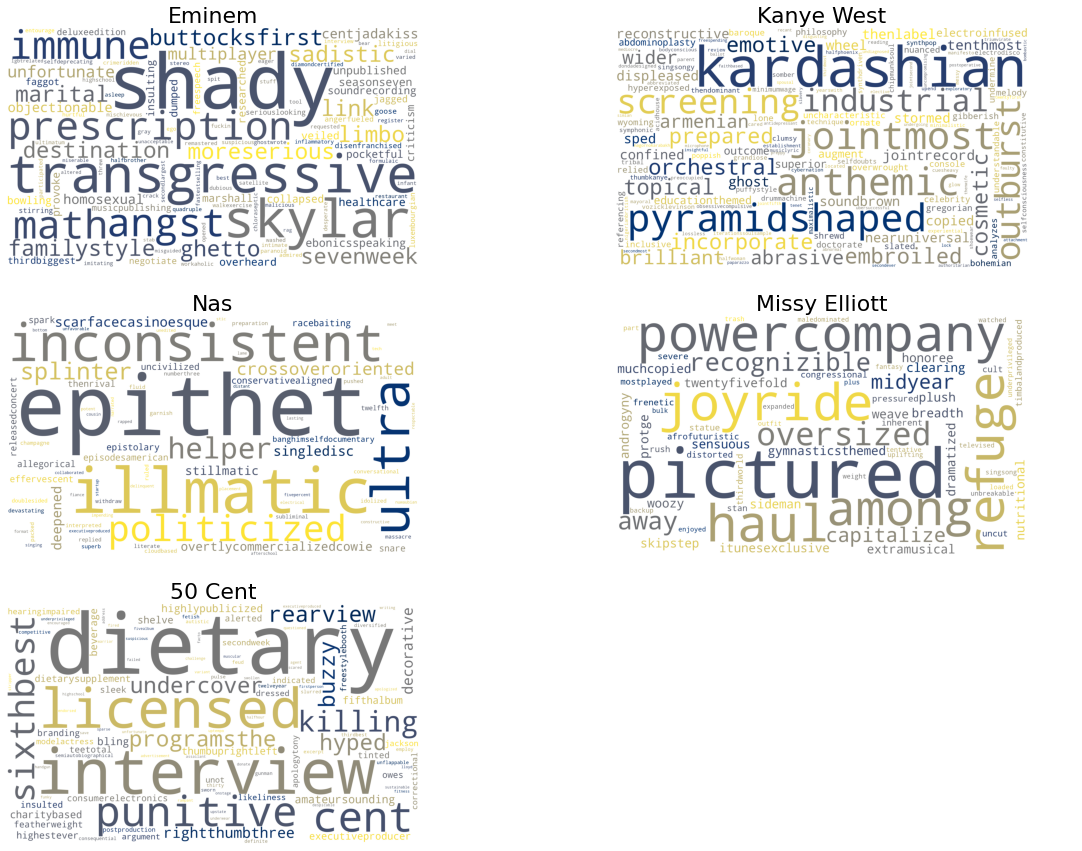

In [93]:
fig, axs = plt.subplots(3,2, figsize=(20,15))

plt.axis("off")

axs[0][0].imshow(wordcloud1)
axs[0][0].set_title("Eminem", fontsize= 22)
axs[1][0].imshow(wordcloud2)
axs[1][0].set_title('Nas', fontsize= 22)
axs[2][0].imshow(wordcloud3)
axs[2][0].set_title('50 Cent', fontsize= 22)
axs[0][1].imshow(wordcloud4)
axs[0][1].set_title('Kanye West', fontsize= 22)
axs[1][1].imshow(wordcloud5)
axs[1][1].set_title('Missy Elliott', fontsize= 22)

axs[0][0].axis('off')
axs[1][0].axis('off')
axs[2][0].axis('off')
axs[0][1].axis('off')
axs[1][1].axis('off')

plt.show()

<a class="anchor" id="fifth-bullet"></a>


### Explainer Notebook

<a class="anchor" id="sixth-bullet"></a></center></h6>

https://github.com/oskargramnielsen/social_graph_2022



Find the file under -> "explainer_notebook"

In [94]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')